## Including Headers

In [1]:
import modelo as m
import pandas as pd
import Bio.KEGG.REST as rkg
import Bio.KEGG.Enzyme as ex
import networkx as nx
import cufflinks as cf
import pylab as pl
import numpy as np
import plotly.tools as tls
import sklearn
import random
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
random.seed(42)

###  First Attempt: Classification with all nodes and using undirected network

In [2]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l):
    '''
        This method in based on:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    '''
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.2f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return(plt)

#### Defining all classifiers and parameters

In [3]:
#All classifiers with default parameters
classifiers = [KNeighborsClassifier(), 
              SVC(probability=True),
              GaussianProcessClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              MLPClassifier(),
              AdaBoostClassifier(),
              GaussianNB()]
cls = ["KNN",
      "SVM linear",
      "SVM RBF",
      "Gauss",
      "AD",
      "RF",
      "MLP",
      "AdaBoost",
      "Net Bayes"]

#### Reading data

In [4]:
sce = pd.read_csv("data/scerevisiae_all.csv")
eco = pd.read_csv("data/ecoli_all.csv")
pae = pd.read_csv("data/paeruginosa_all.csv")
mge = pd.read_csv("data/mgenitalium_all.csv")

#### Splitting train and test datasets

In [5]:
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']
eco_x, eco_y = eco.iloc[:,2:-1],eco['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
# Class redefinition 0:essential 1:unknown/non-essential
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

#### Machine Learning pairwise

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations re

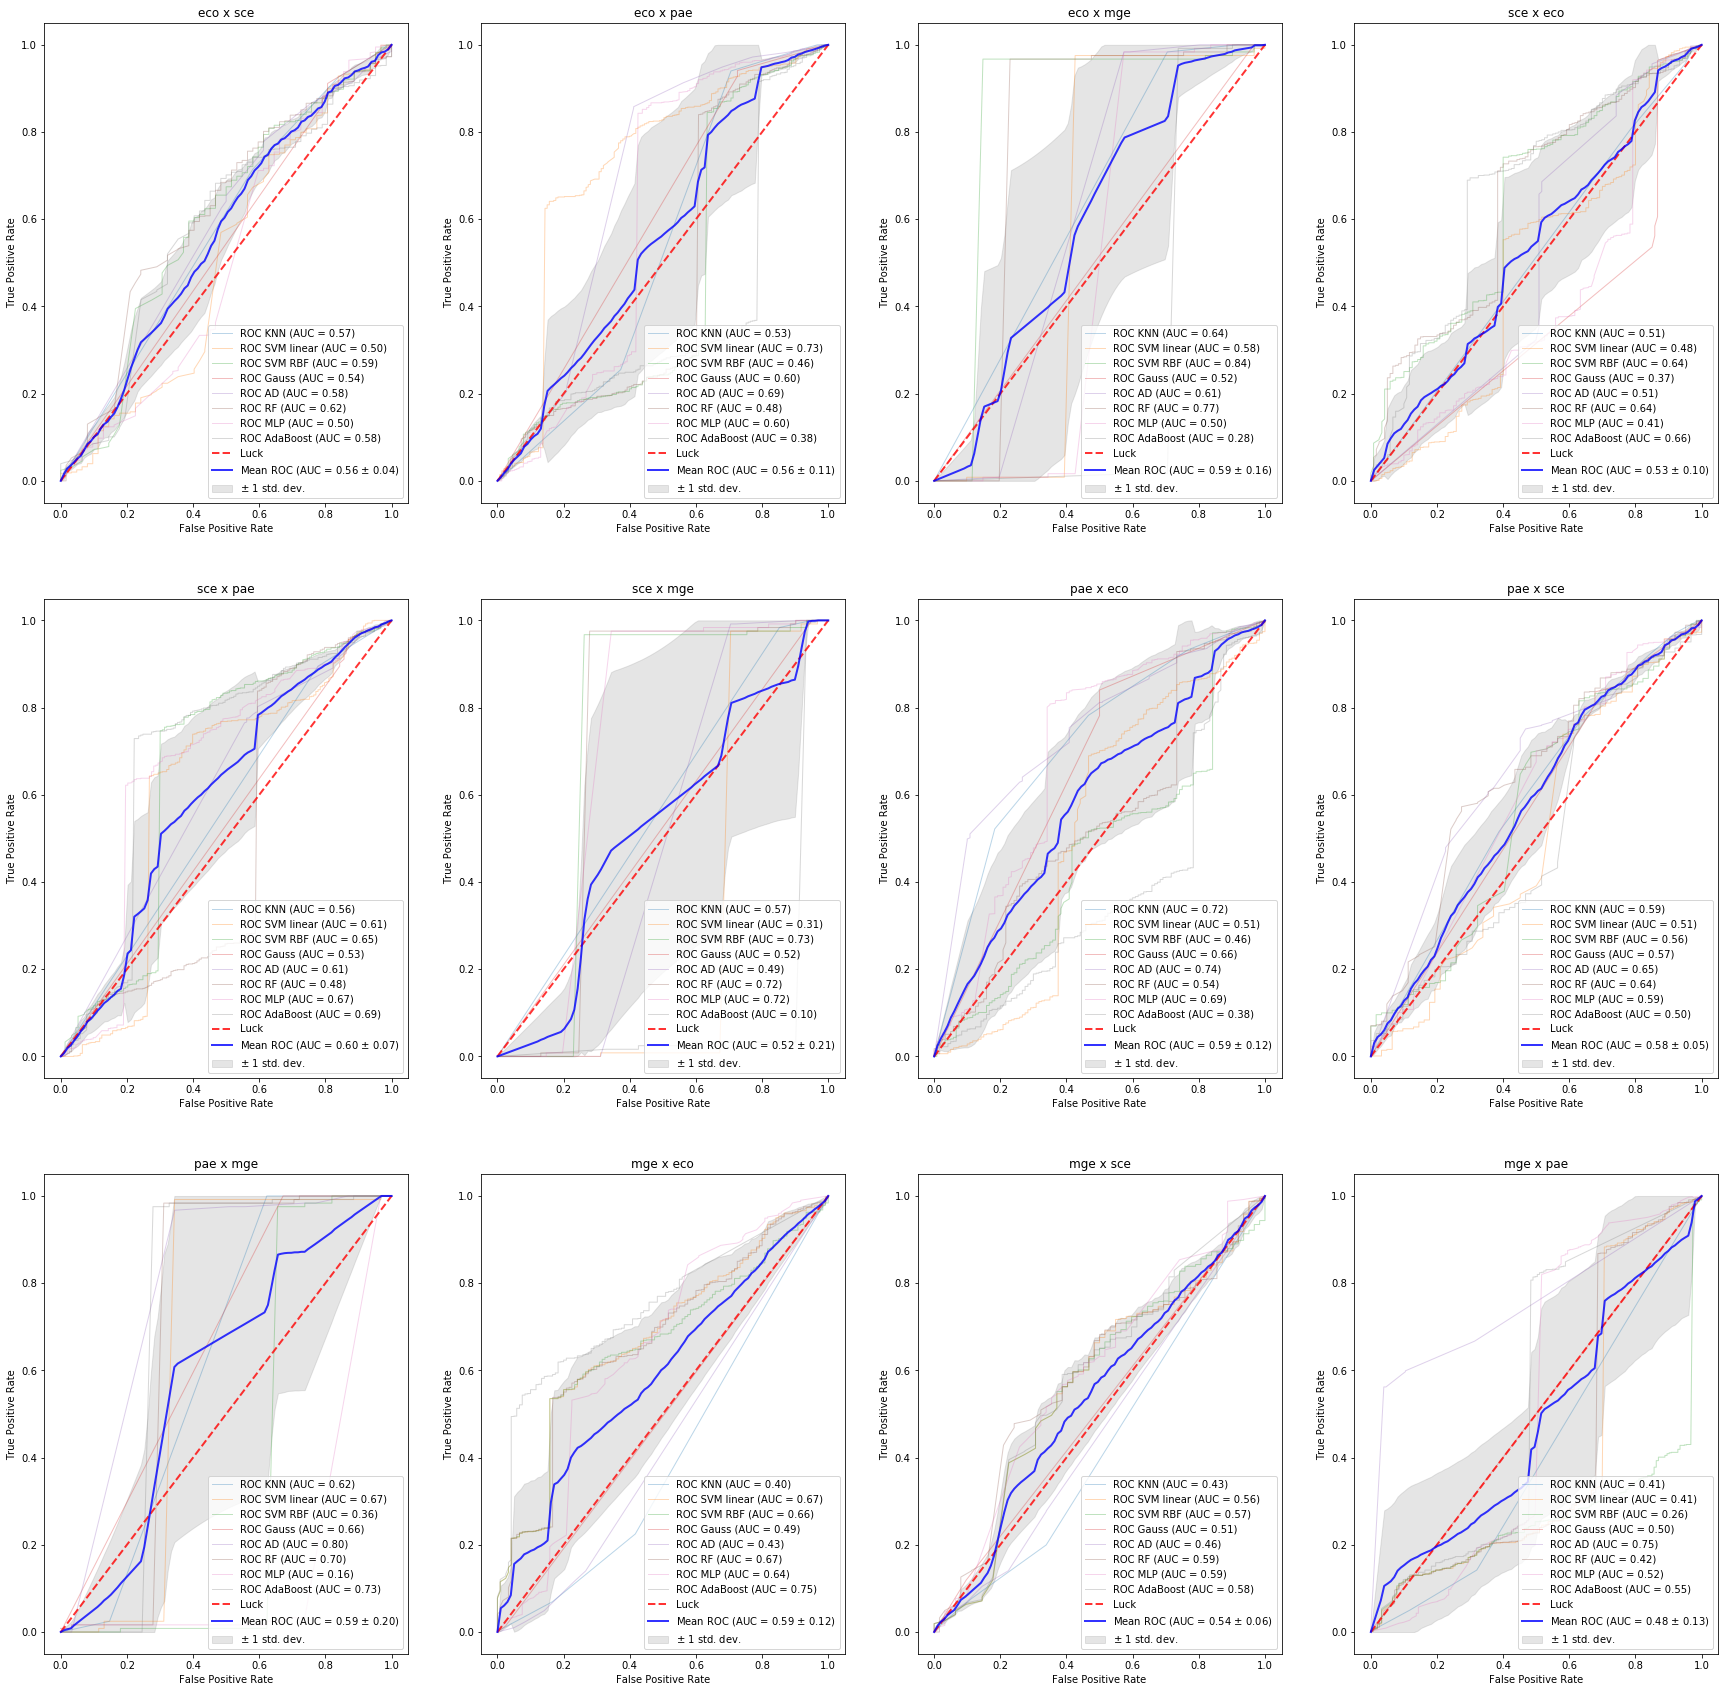

In [6]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 3
col = 4
runtimes = []
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        if i[2] != j[2]:
            tprs_dall = []
            aucs_dall = []
            mean_fpr_dall = np.linspace(0, 1, 100)
            a = fig.add_subplot(row, col, pcount)
            s = time.time()
            imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
            runtimes.append(time.time() - s)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
plt.show()

In [7]:
print("Time for machine learning tests\n")
for i in zip(cls, runtimes):
    print("Classifier: ", i[0], " / Runtime: ", i[1], " seconds")

Time for machine learning tests

Classifier:  KNN  / Runtime:  25.306148529052734  seconds
Classifier:  SVM linear  / Runtime:  24.432780504226685  seconds
Classifier:  SVM RBF  / Runtime:  6.302124738693237  seconds
Classifier:  Gauss  / Runtime:  20.68769907951355  seconds
Classifier:  AD  / Runtime:  18.50876212120056  seconds
Classifier:  RF  / Runtime:  4.329668283462524  seconds
Classifier:  MLP  / Runtime:  23.45665454864502  seconds
Classifier:  AdaBoost  / Runtime:  18.641338109970093  seconds
Classifier:  Net Bayes  / Runtime:  5.4900994300842285  seconds


#### Building dataset: Leave one out strategy

In [8]:
#All classifiers with default parameters
classifiers = [KNeighborsClassifier(), 
              SVC(probability=True),
              GaussianProcessClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              MLPClassifier(),
              AdaBoostClassifier(),
              GaussianNB()]
cls = ["KNN",
      "SVM linear",
      "SVM RBF",
      "Gauss",
      "AD",
      "RF",
      "MLP",
      "AdaBoost",
      "Net Bayes"]

In [9]:
train1_x = pd.concat([sce_x,mge_x,pae_x])
train1_y = pd.concat([sce_y,mge_y,pae_y])
test1_x = eco_x 
test1_y = eco_y
#------------------------------------------------------------------------------------
train2_x = pd.concat([eco_x,mge_x,pae_x])
train2_y = pd.concat([eco_y,mge_y,pae_y])
test2_x = sce_x 
test2_y = sce_y
#------------------------------------------------------------------------------------
train3_x = pd.concat([eco_x,sce_x,pae_x])
train3_y = pd.concat([eco_y,sce_y,pae_y])
test3_x = mge_x 
test3_y = mge_y
#------------------------------------------------------------------------------------
train4_x = pd.concat([eco_x,sce_x,mge_x])
train4_y = pd.concat([eco_y,sce_y,mge_y])
test4_x = pae_x 
test4_y = pae_y

#### Testing Machine Learning Classifiers 

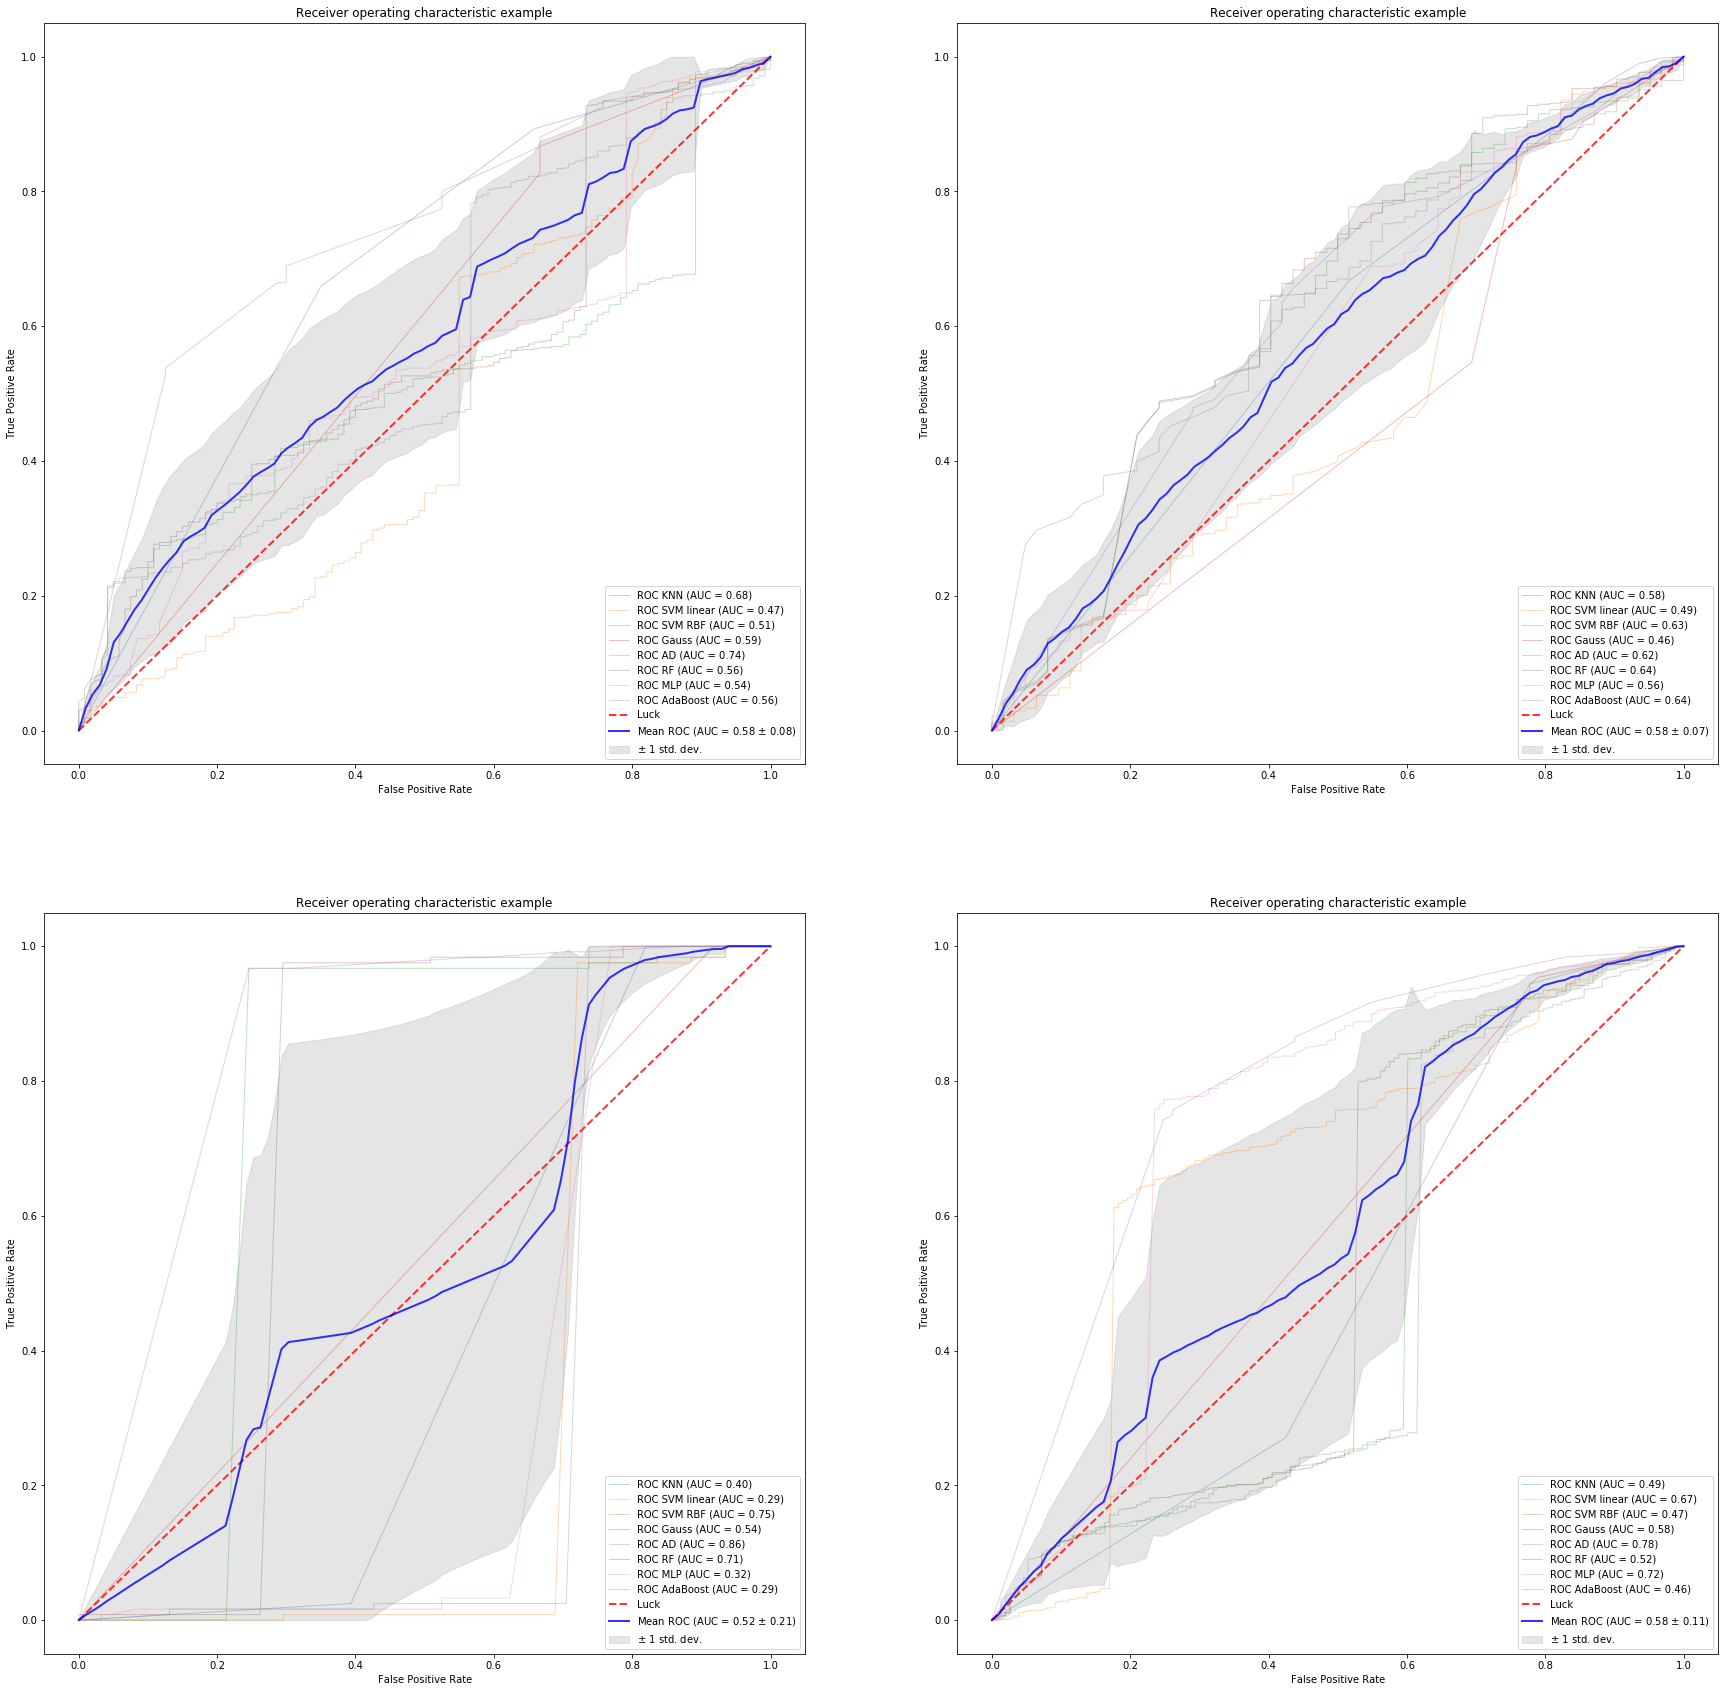

In [10]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(train1_x,train1_y,test1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 = time.time() - s1 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(train2_x,train2_y,test2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 =  time.time() -s2 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(train3_x,train3_y,test3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(train4_x,train4_y,test4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 = time.time() - s4

plt.show()

In [11]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

Time for machine learning test

Dataset1: --- 112.11966300010681 seconds ---
Dataset2: --- 93.9938371181488 seconds ---
Dataset3: --- 40.55887818336487 seconds ---
Dataset4: --- 92.1058521270752 seconds ---


###  Second Attempt: Classification without isolate nodes and using undirected network

#### Reading data

In [12]:
sce = pd.read_csv("data/scerevisiae.csv")
eco = pd.read_csv("data/ecoli.csv")
pae = pd.read_csv("data/paeruginosa.csv")
mge = pd.read_csv("data/mgenitalium.csv")

#### Splitting train and test datasets

In [13]:
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']
eco_x, eco_y = eco.iloc[:,2:-1],eco['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
# Class redefinition 0:essential 1:unknown/non-essential
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

#### Machine Learning pairwise

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.

C:\Users\herio\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



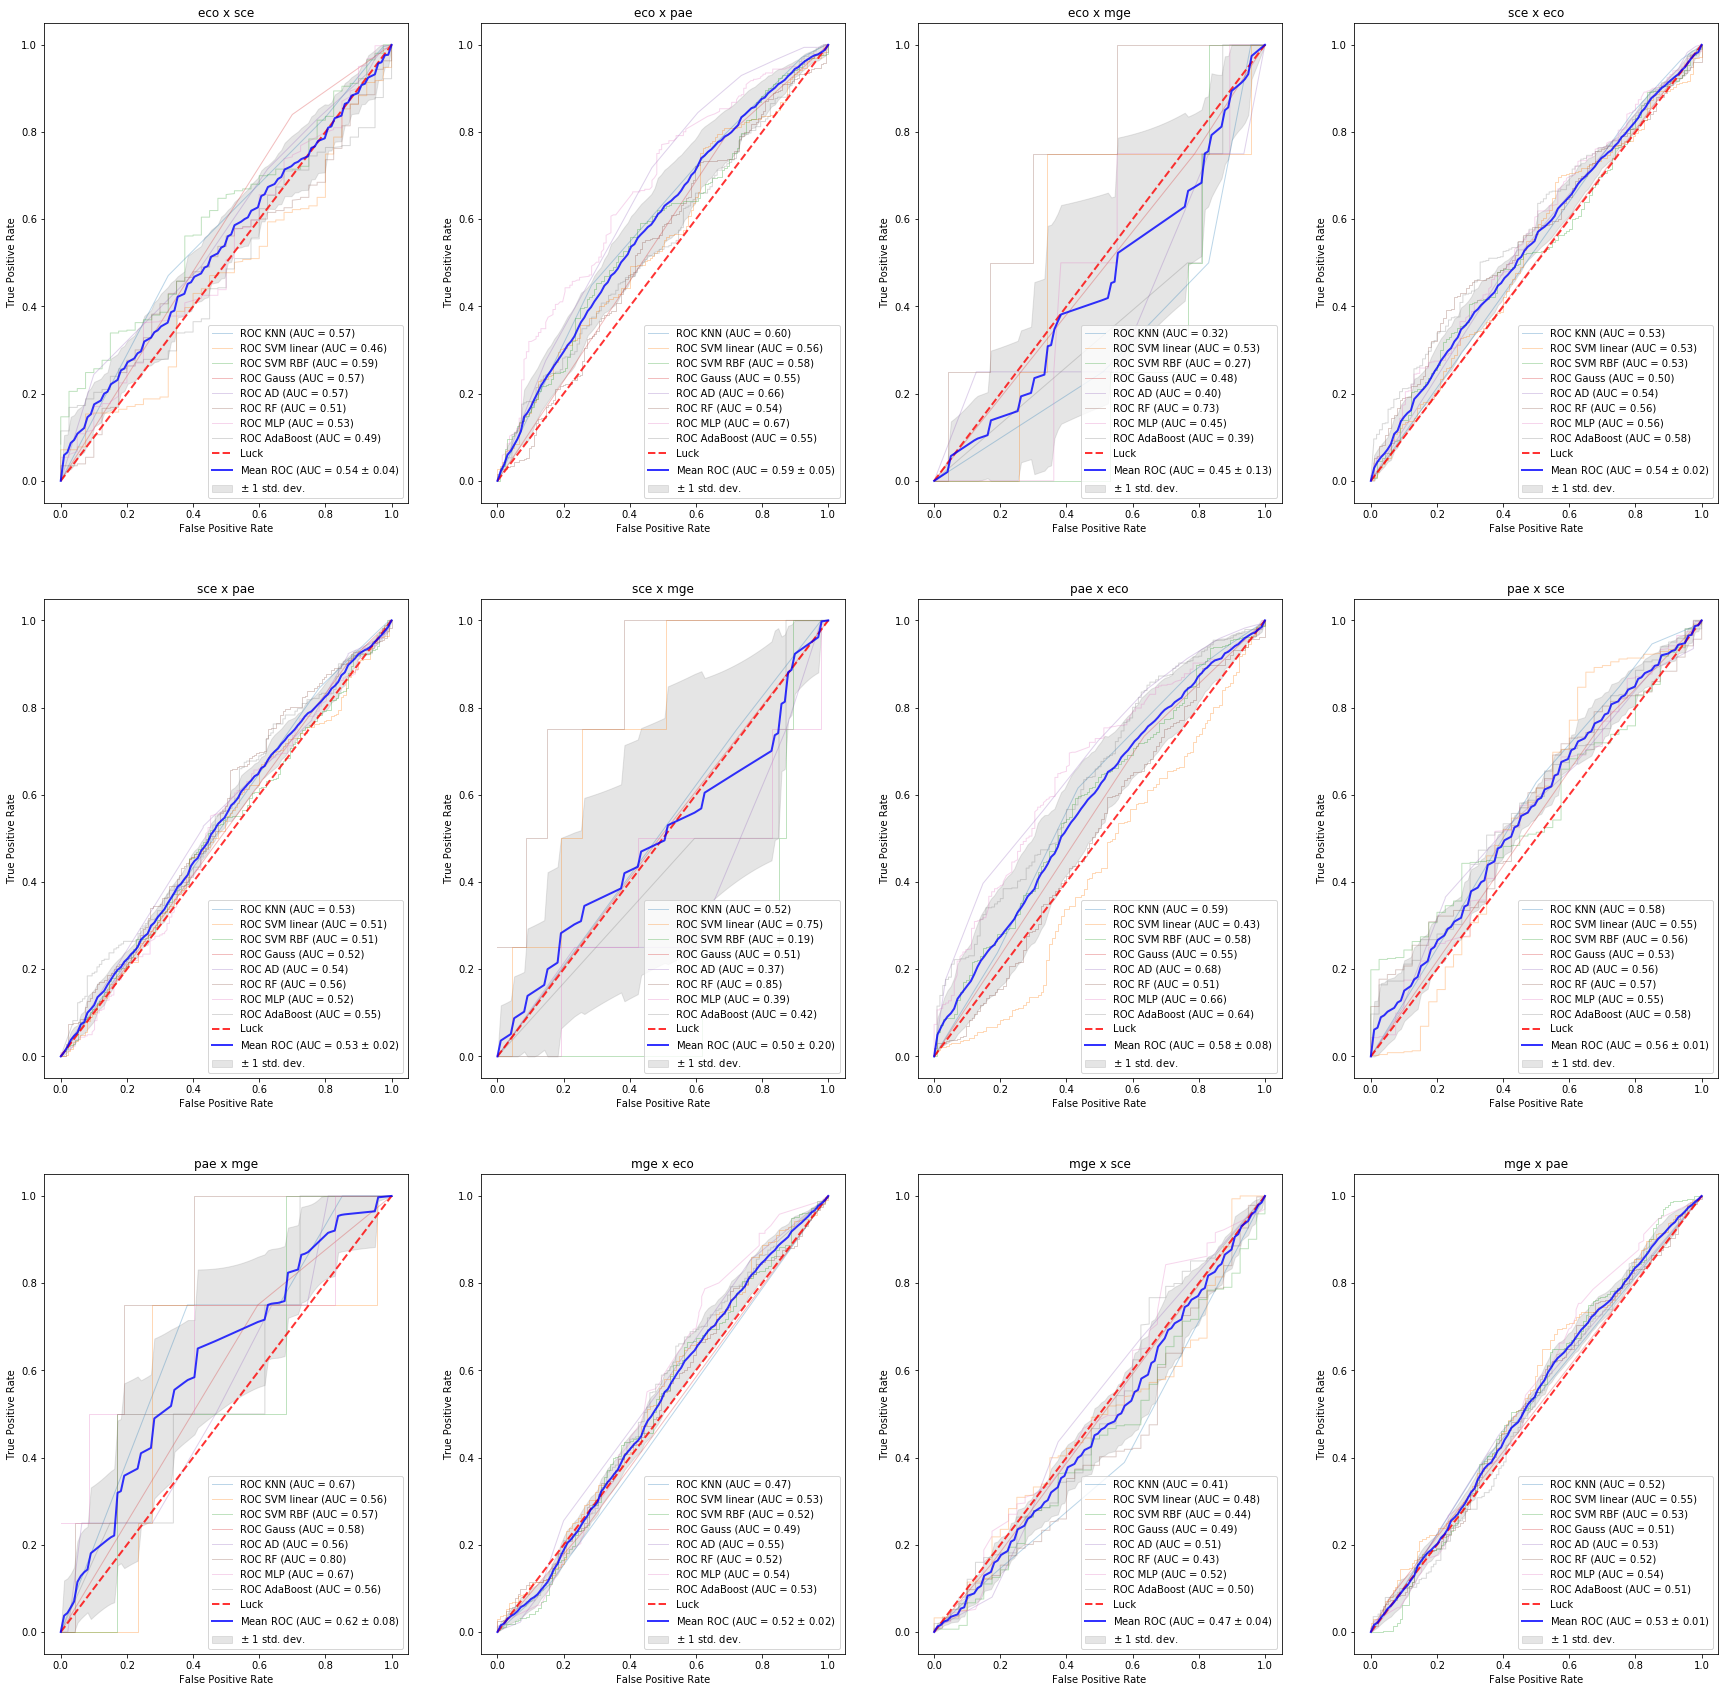

In [14]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 3
col = 4
runtimes = []
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        if i[2] != j[2]:
            tprs_dall = []
            aucs_dall = []
            mean_fpr_dall = np.linspace(0, 1, 100)
            a = fig.add_subplot(row, col, pcount)
            s = time.time()
            imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
            runtimes.append(time.time() - s)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
plt.show()

In [15]:
print("Time for machine learning tests\n")
for i in zip(cls, runtimes):
    print("Classifier: ", i[0], " / Runtime: ", i[1], " seconds")

Time for machine learning tests

Classifier:  KNN  / Runtime:  3.120415449142456  seconds
Classifier:  SVM linear  / Runtime:  2.961038589477539  seconds
Classifier:  SVM RBF  / Runtime:  0.9432966709136963  seconds
Classifier:  Gauss  / Runtime:  2.216978073120117  seconds
Classifier:  AD  / Runtime:  1.6096241474151611  seconds
Classifier:  RF  / Runtime:  0.6192474365234375  seconds
Classifier:  MLP  / Runtime:  1.706615686416626  seconds
Classifier:  AdaBoost  / Runtime:  1.3798885345458984  seconds
Classifier:  Net Bayes  / Runtime:  0.48684191703796387  seconds


#### Building dataset: Leave one out strategy

In [16]:
train1_x = pd.concat([sce_x,mge_x,pae_x])
train1_y = pd.concat([sce_y,mge_y,pae_y])
test1_x = eco_x 
test1_y = eco_y
#------------------------------------------------------------------------------------
train2_x = pd.concat([eco_x,mge_x,pae_x])
train2_y = pd.concat([eco_y,mge_y,pae_y])
test2_x = sce_x 
test2_y = sce_y
#------------------------------------------------------------------------------------
train3_x = pd.concat([eco_x,sce_x,pae_x])
train3_y = pd.concat([eco_y,sce_y,pae_y])
test3_x = mge_x 
test3_y = mge_y
#------------------------------------------------------------------------------------
train4_x = pd.concat([eco_x,sce_x,mge_x])
train4_y = pd.concat([eco_y,sce_y,mge_y])
test4_x = pae_x 
test4_y = pae_y

#### Testing Machine Learning Classifiers 

In [17]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(train1_x,train1_y,test1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 = time.time() - s1 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(train2_x,train2_y,test2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 = time.time() - s2 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(train3_x,train3_y,test3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4 = time.time()
imgshow = roc(train4_x,train4_y,test4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 = time.time() - s4

In [18]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

Time for machine learning test

Dataset1: --- 9.585752248764038 seconds ---
Dataset2: --- 10.116300821304321 seconds ---
Dataset3: --- 4.801523208618164 seconds ---
Dataset4: --- 10.314594745635986 seconds ---
